In [9]:
from typing import Any
import pandas as pd
from sklearn.model_selection import train_test_split
from sklift.datasets import fetch_hillstrom
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier
from category_encoders import CatBoostEncoder

In [2]:
def get_data() -> tuple[Any, Any, Any]:
	# получаем датасет
	dataset = fetch_hillstrom(target_col='visit')
	dataset, target, treatment = dataset['data'], dataset['target'], dataset['treatment']
	# выбираем два сегмента
	dataset = dataset[treatment != 'Mens E-Mail']
	target = target[treatment != 'Mens E-Mail']
	treatment = treatment[treatment != 'Mens E-Mail'].map({
		'Womens E-Mail': 1,
		'No E-Mail':     0
	})

	return dataset, target, treatment

In [3]:
data, target, treatment = get_data()

In [4]:
data.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web
5,6,2) $100 - $200,134.83,0,1,Surburban,0,Phone


In [5]:
target.head()

0    0
1    0
2    0
4    0
5    1
Name: visit, dtype: int64

In [6]:
treatment.head()

0    1
1    0
2    1
4    1
5    1
Name: segment, dtype: int64

In [23]:
pd.crosstab(treatment, target, normalize='index')

visit,0,1
segment,,
0,0.893833,0.106167
1,0.848600,0.151400


In [50]:
res = data.newbie.value_counts(normalize=True) * 100
display(res)

1    50.261167
0    49.738833
Name: newbie, dtype: float64

In [54]:
data.zip_code.value_counts()

Surburban    19275
Urban        17098
Rural         6320
Name: zip_code, dtype: int64

In [12]:
X_train, X_val, y_train, y_val, trmnt_train, trmnt_val = train_test_split(
    data, target, treatment, test_size=0.3, random_state=42
)

models_results = {
    'approach': [],
    'uplift@30%': []
}

## Single model

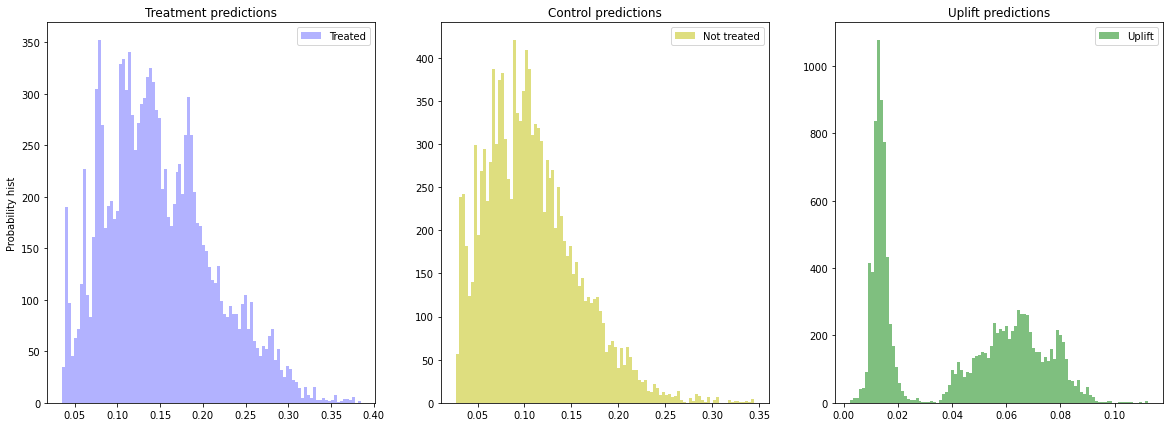

In [13]:
sm = SoloModel(CatBoostClassifier(iterations=1000, task_type="GPU", random_state=42, silent=True))
sm = sm.fit(X_train, y_train, trmnt_train, estimator_fit_params={'cat_features': ['history_segment', 'zip_code', 'channel']})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=trmnt_val, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [14]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,newbie,16.159375
1,history,15.380477
2,recency,15.057106
3,womens,12.918455
4,treatment,12.083391
5,channel,9.437116
6,zip_code,9.357430
7,mens,6.807001
8,history_segment,2.799648


## Class transform

In [15]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=1000, task_type='GPU', random_state=42, silent=True))
ct = ct.fit(X_train, y_train, trmnt_train, estimator_fit_params={'cat_features': ['history_segment', 'zip_code', 'channel']})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=trmnt_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

## Two independent models

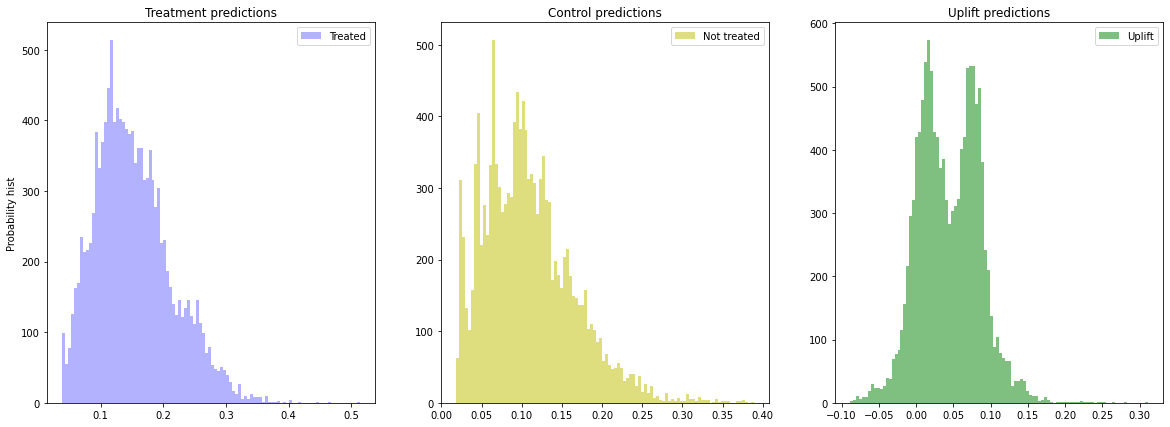

In [16]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=1000, task_type='GPU', random_state=42, silent=True),
    estimator_ctrl=CatBoostClassifier(iterations=1000, task_type='GPU', random_state=42, silent=True),
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, trmnt_train,
    estimator_trmnt_fit_params={'cat_features': ['history_segment', 'zip_code', 'channel']},
    estimator_ctrl_fit_params={'cat_features': ['history_segment', 'zip_code', 'channel']}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=trmnt_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

## Two dependend models

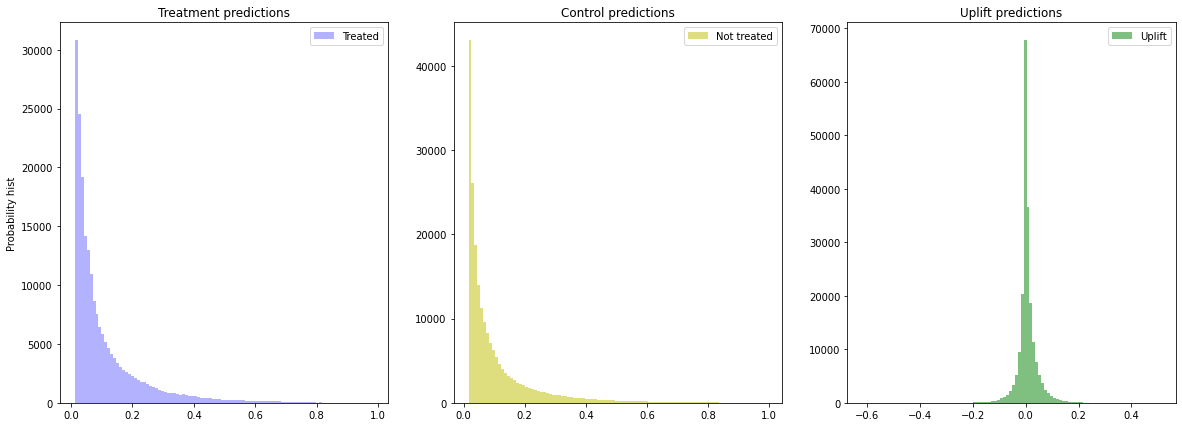

In [36]:
tm_ctrl = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=1000, task_type='GPU', random_state=42, silent=True),
    estimator_ctrl=CatBoostClassifier(iterations=1000, task_type='GPU', random_state=42, silent=True),
    method='ddr_control'
)
tm_ctrl = tm_ctrl.fit(
    X_train, y_train, trmnt_train,
    estimator_trmnt_fit_params={'cat_features': ['gender']},
    estimator_ctrl_fit_params={'cat_features': ['gender']}
)

uplift_tm_ctrl = tm_ctrl.predict(X_val)

tm_ctrl_score = uplift_at_k(y_true=y_val, uplift=uplift_tm_ctrl, treatment=trmnt_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels_ddr_control')
models_results['uplift@30%'].append(tm_ctrl_score)

plot_uplift_preds(trmnt_preds=tm_ctrl.trmnt_preds_, ctrl_preds=tm_ctrl.ctrl_preds_);

In [47]:
pd.DataFrame([tm_ctrl.trmnt_preds_, uplift_tm_ctrl])

,0,1,2,3,4,5,6,7,8,9,...,206099,206100,206101,206102,206103,206104,206105,206106,206107,206108
0,0.116088,0.269822,0.049340,0.038516,0.143292,0.047044,0.018165,0.086771,0.137409,0.029504,...,0.191889,0.044686,0.069574,0.170429,0.384708,0.022230,0.020183,0.043997,0.283808,0.053526
1,0.045442,0.041342,-0.018277,0.012866,0.028861,0.007020,-0.001542,0.047911,-0.013122,-0.004837,...,0.076940,-0.005309,0.033985,-0.097014,-0.093607,0.002797,0.000479,0.014596,-0.098411,0.024334


## Results

In [37]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
3,ClassTransformation,0.031702
4,TwoModels,0.016004
1,SoloModel,0.013953
2,SoloModel,0.013411
5,TwoModels_ddr_control,0.011537
0,SoloModel,0.006042


C:\Users\HardWorkingStation\PyProjects\uplift_lab\venv\lib\site-packages\numpy\core\fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


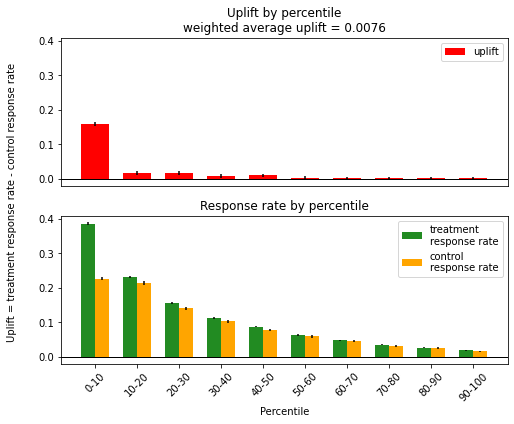

In [39]:
from sklift.viz import plot_uplift_by_percentile

# line plot
plot_uplift_by_percentile(y_val, uplift_ct, trmnt_val, strategy='overall', kind='bar');

In [48]:
type(dataset)

sklearn.utils._bunch.Bunch